<a href="https://colab.research.google.com/github/leilaabdel/ece-638-projects/blob/master/project-2/la_dip_project_2_chinese_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-wrapper

     |████████████████████████████████| 17.3MB 1.2MB/s 
     |████████████████████████████████| 25.4MB 108kB/s 
  Created wheel for opencv-wrapper: filename=opencv_wrapper-0.2.3-py2.py3-none-any.whl size=18581 sha256=586e5d67084568d5edbada21acfbf442e9560e6788ee660c2c724ba085f62b96
  Stored in directory: /root/.cache/pip/wheels/74/fc/22/03106b3bcb2516e69317562a2aa4ceb94b0d5813a448edd928
Successfully built opencv-wrapper
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled

In [ ]:
import tensorflow as tf
import cv2
import PIL
from google.colab.patches import cv2_imshow
import numpy as np
import imutils

# Get the Data

In [ ]:
!cp '/content/drive/My Drive/Masters-Program/courses/ece-638-digital-image-processing/Project-2/data/ChineseAlphabet.zip' . 
!cp '/content/drive/My Drive/Masters-Program/courses/ece-638-digital-image-processing/Project-2/data/SampleTestImages.zip' .

In [ ]:
!cp '/content/drive/My Drive/Masters-Program/courses/ece-638-digital-image-processing/Project-2/data/my-data.png' .

In [ ]:
!unzip '/content/ChineseAlphabet.zip'
!unzip '/content/SampleTestImages.zip'

unzip:  cannot find or open /content/ChineseAlphabet.zip, /content/ChineseAlphabet.zip.zip or /content/ChineseAlphabet.zip.ZIP.
unzip:  cannot find or open /content/SampleTestImages.zip, /content/SampleTestImages.zip.zip or /content/SampleTestImages.zip.ZIP.


# Preprocess the Data

In [ ]:
import cv2
import opencv_wrapper as cvw


IMAGE = "/content/my-data.png"

def find_rois(img):
  print("Using the last 13 letters of the alphabet!")
  image = cv2.imread(img)
  gray = cvw.bgr2gray(image)

  img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]

  if np.count_nonzero(gray)/(gray.shape[0] * gray.shape[1]) < 0.9:
    gray = 255 - gray

  thresh = cvw.threshold_otsu(gray, inverse=True)



  # dilation
  img_dilation = cvw.dilate(thresh, 5)

  # Find contours
  contours = cvw.find_external_contours(img_dilation)
  # Map contours to bounding rectangles, using bounding_rect property
  rects = map(lambda c: c.bounding_rect, contours)
  # Sort rects by top-left x (rect.x == rect.tl.x)
  sorted_rects = sorted(rects, key=lambda r: r.x)

  # Distance threshold
  dt = 1

  # List of final, joined rectangles
  final_rects = [sorted_rects[0]]

  for rect in sorted_rects[1:]:
      prev_rect = final_rects[-1]

      # Shift rectangle `dt` back, to find out if they overlap
      shifted_rect = cvw.Rect(rect.tl.x - dt, rect.tl.y, rect.width, rect.height)
      intersection = cvw.rect_intersection(prev_rect, shifted_rect)
      if intersection is not None:
          # Join the two rectangles
          min_y = min((prev_rect.tl.y, rect.tl.y))
          max_y = max((prev_rect.bl.y, rect.bl.y))
          max_x = max((prev_rect.br.x, rect.br.x))
          width = max_x - prev_rect.tl.x
          height = max_y - min_y
          new_rect = cvw.Rect(prev_rect.tl.x, min_y, width, height)
          # Add new rectangle to final list, making it the new prev_rect
          # in the next iteration
          final_rects[-1] = new_rect
      else:
          # If no intersection, add the box
          final_rects.append(rect)

  for rect in sorted_rects:
      cvw.rectangle(image, rect, cvw.Color.MAGENTA, line_style=cvw.LineStyle.DASHED)

  for rect in final_rects:
      cvw.rectangle(image, rect, cvw.Color.GREEN, thickness=2)

  cv2.imwrite("result.png", image)

  return final_rects


rois = find_rois(IMAGE)
# draw_rois(IMAGE, rois)

In [ ]:
def filter_rois(rois , im_path , threshold=0.001):
  image = cv2.imread(im_path)
  filtered_rects = []
  for rect in rois:
    if rect.area > threshold * image.shape[0] * image.shape[1]:
      filtered_rects.append(rect)

  return filtered_rects

filtered_rects = filter_rois(rois , IMAGE)



In [ ]:
def draw_rois(im_path , roi_rects):
  image = cv2.imread(im_path)
  gray = cvw.bgr2gray(image)

  # Correct for black background
  if np.count_nonzero(gray)/(gray.shape[0] * gray.shape[1]) < 0.9:
    image = 255 - image


  for rect in roi_rects:
      cvw.rectangle(image, rect, cvw.Color.GREEN, thickness=2)

  cv2.imwrite("filtered-result.png", image)

draw_rois(IMAGE , filtered_rects)

In [ ]:
import tensorflow as tf
def get_embeddings(filtered_rects , IMAGE_PATH, mode="TEST" , filtersize=5 , slide=1 , pooling=0):

  assert filtersize >= 2
  assert slide > 0
  assert pooling == 1 or pooling == 0
  cropped_ims = []

  for i , rect in enumerate(filtered_rects):
    image = cv2.imread(IMAGE_PATH , cv2.IMREAD_GRAYSCALE)
    image = 255 - image
    if np.count_nonzero(image)/(image.shape[0] * image.shape[1]) < 0.9:
      image = 255 - image
    crop_img = image[rect.y:rect.y+rect.height , rect.x:rect.x+rect.width]
    crop_img = cv2.threshold(crop_img, 50, 255, cv2.THRESH_BINARY)[1]

    resized_image = cv2.resize(crop_img, (28, 28)) 
    cropped_ims += [np.asarray(resized_image)]
    #cv2.imwrite(f"cropped-roi-{i}-inverted.png", resized_image)



  cropped_ims = np.asarray(cropped_ims, dtype='float32')
  X_train = np.zeros((1 ,28 , 28))

  for i in range(1):
    X_train = np.concatenate((X_train , cropped_ims))

  X_train = np.asarray(X_train)
  X_train_n = X_train[np.newaxis, 1: , : , : , np.newaxis]

  X_train_n = X_train_n / 255.


  #### GET THE PROJECTIONS ####
   
    
  translations = {}
  letter_ims = {}
  alphabet = ['M', 'N' , 'O' , 'P' , 'Q' , 'R' , 'S' , 'T' , 'U' , 
              'V' , 'W' , 'X' , 'Y']

  X = []

  cropped_ims = cropped_ims / 255.0

  if mode == 'TRAIN':
    for i in range(len(alphabet)):

      if pooling == 0:
        down_sampled = tf.nn.avg_pool2d(X_train_n[: , i] , filtersize , slide , padding="VALID")
      else:
        down_sampled = tf.nn.max_pool2d(X_train_n[: , i] , filtersize , slide , padding="VALID")

      translations[alphabet[i]] = np.squeeze(down_sampled)
      letter_ims[alphabet[i]] =  np.squeeze(X_train_n[: , i])


    return translations , letter_ims

  elif mode =='TEST':

    for i in range(len(filtered_rects)):

      if pooling == 0:
        down_sampled = tf.nn.avg_pool2d(X_train_n[: , i] , filtersize , slide , padding="VALID")
      else:
        down_sampled = tf.nn.max_pool2d(X_train_n[: , i] , filtersize , slide , padding="VALID")

      X += [down_sampled]

    return  np.squeeze(np.array(X)) , cropped_ims / 255.

  else:
     return -1 

LETTER_VALUES , train_ims = get_embeddings(filtered_rects , 'my-data.png' , mode='TRAIN')

In [ ]:
def predict(X_test , translations, cutoff=3.5):
  print(X_test.shape)
  if len(X_test.shape) == 2:

    dists = []
    eng_letters = []

    for keys, values in translations.items():
      dist = np.linalg.norm((X_test - values) , 2) 
      dists.append(dist)
      eng_letters.append(keys)

    min_dist = np.argmin(dists)

    if np.amin(dists) < cutoff:
      return eng_letters[min_dist]

    else:
      return "I don't know this letter"

  elif len(X_test.shape) == 3:
    predicted_sequence = []
    for test_im in X_test:
      dists = []
      eng_letters = []

      for keys, values in translations.items():
        dist = np.linalg.norm((test_im - values) , 2) 
        dists.append(dist)
        eng_letters.append(keys)

      min_dist = np.argmin(dists)

      if np.amin(dists) < cutoff:
        predicted_sequence +=  [eng_letters[min_dist]]

      else:
        predicted_sequence += ['-1']

    return predicted_sequence




In [ ]:
TEST_PATH = 'noisy-image.png'

rois = find_rois(TEST_PATH)
filtered_rects_test = filter_rois(rois , TEST_PATH)
draw_rois(TEST_PATH , filtered_rects_test)
embedds , test_ims = get_embeddings(filtered_rects_test, IMAGE_PATH=TEST_PATH)

(24, 24)

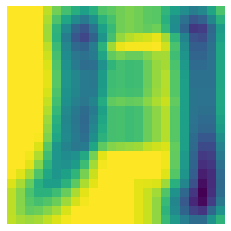

In [ ]:
plt.imshow(embedds[1])
plt.axis('off')
embedds[1].shape

(-0.5, 23.5, 23.5, -0.5)

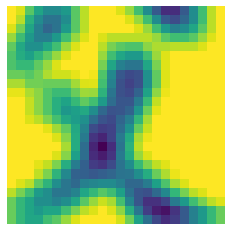

In [ ]:
plt.imshow(LETTER_VALUES['X'])
plt.axis('off')

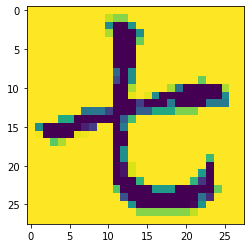

In [ ]:
plt.imshow(test_ims[13])

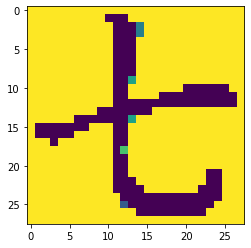

In [ ]:
plt.imshow(train_ims['T'])

# Evaluate


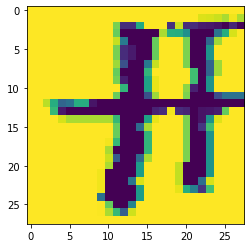

In [ ]:
plt.imshow(test_ims[24])

In [ ]:
GROUND_TRUTH = ['M' , '-1' , 'N' , '-1', 'O' , 
                '-1' , 'P' , '-1' , 
                'Q' , 'R', '-1' , 
                'S' , '-1' , 'T' , 'U' , 
                '-1' , 'V' , '-1' , 'W' , 
                '-1' , '-1' , 'X' , '-1' ,
                'Y' , 'M']

len(GROUND_TRUTH)

25

In [ ]:
predictions = predict(embedds , LETTER_VALUES, cutoff=3.0)

(25, 24, 24)


In [ ]:
def evaluate(X , Y):
  counter = 0
  for i in range(len(X)):
    if X[i] == Y[i]:
      counter += 1

  return counter / len(X)

In [ ]:
evaluate(predictions , GROUND_TRUTH)

0.68

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(GROUND_TRUTH)

transformed_gt = le.transform(GROUND_TRUTH)
transformed_pred = le.transform(predictions)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(predictions , GROUND_TRUTH , average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7381818181818182, 0.68, 0.7066666666666667, None)

# Experiments

## Hyperparam Grid Search

In [ ]:
TEST_PATH = 'testcase1.png'
rois = find_rois(TEST_PATH)
filtered_rects_test = filter_rois(rois , TEST_PATH)
draw_rois(TEST_PATH , filtered_rects_test)

BEST_F1 = -1

filter_search = [2 , 3 , 4 , 5 , 6]
slide_search = [1 , 2 , 3 , 4 , 5]
pooling = [0 , 1]

genotype = [[0 , 0 , 0]]
f1s = []

for f in filter_search:
  for s in slide_search:  
    for p in pooling:
      LETTER_VALUES , train_ims = get_embeddings(filtered_rects , 'my-data.png' , mode='TRAIN' , filtersize=f , slide=s , pooling=p)
      embedds , test = get_embeddings(filtered_rects_test , TEST_PATH , filtersize=f , slide=s , pooling=p)
      print(embedds.shape)
      predictions = predict(embedds , LETTER_VALUES, cutoff=3.0)
      # transformed_pred = le.transform(predictions)
      f1 = precision_recall_fscore_support(predictions , GROUND_TRUTH , average='weighted')[0]
      f1s.append(f1)
      genotype.append([f , s , p])





(25, 27, 27)
(25, 27, 27)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(25, 27, 27)
(25, 27, 27)
(25, 14, 14)
(25, 14, 14)
(25, 14, 14)
(25, 14, 14)
(25, 9, 9)
(25, 9, 9)
(25, 9, 9)
(25, 9, 9)
(25, 7, 7)
(25, 7, 7)
(25, 7, 7)
(25, 7, 7)
(25, 6, 6)
(25, 6, 6)
(25, 6, 6)
(25, 6, 6)
(25, 26, 26)
(25, 26, 26)
(25, 26, 26)
(25, 26, 26)
(25, 13, 13)
(25, 13, 13)
(25, 13, 13)
(25, 13, 13)
(25, 9, 9)
(25, 9, 9)
(25, 9, 9)
(25, 9, 9)
(25, 7, 7)
(25, 7, 7)
(25, 7, 7)
(25, 7, 7)
(25, 6, 6)
(25, 6, 6)
(25, 6, 6)
(25, 6, 6)
(25, 25, 25)
(25, 25, 25)
(25, 25, 25)
(25, 25, 25)
(25, 13, 13)
(25, 13, 13)
(25, 13, 13)
(25, 13, 13)
(25, 9, 9)
(25, 9, 9)
(25, 9, 9)
(25, 9, 9)
(25, 7, 7)
(25, 7, 7)
(25, 7, 7)
(25, 7, 7)
(25, 5, 5)
(25, 5, 5)
(25, 5, 5)
(25, 5, 5)
(25, 24, 24)
(25, 24, 24)
(25, 24, 24)
(25, 24, 24)
(25, 12, 12)
(25, 12, 12)
(25, 12, 12)
(25, 12, 12)
(25, 8, 8)
(25, 8, 8)
(25, 8, 8)
(25, 8, 8)
(25, 6, 6)
(25, 6, 6)
(25, 6, 6)
(25, 6, 6)
(25, 5, 5)
(25, 5, 5)
(25, 5, 5)
(25, 5, 5)
(25, 23, 23)
(25, 23, 23)
(25, 23, 23)
(25, 23, 23)
(25, 12, 12)
(25, 12, 12)
(25,

In [ ]:
best = np.argmax(f1s)
genotype[best]

[3, 5, 0]

In [ ]:
f1s

In [ ]:
genenp = np.array(genotype)
genenp[:,1].shape

(51,)

## Plotting

In [ ]:
sns.set(font_scale=2.5)
sns.set_style("white")
#!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
import matplotlib as mpl
import matplotlib.font_manager as fm
fm.fontManager.ttflist += fm.createFontList(['/content/times new roman.ttf'])
mpl.rc('font', family='Serif')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  


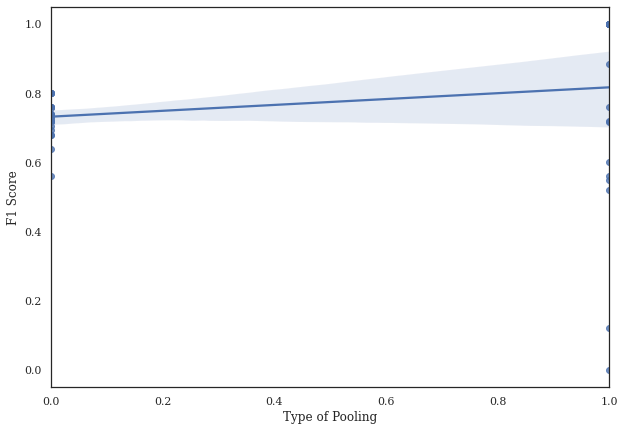

In [ ]:
import seaborn as sns
import pandas as pd
fig = plt.figure(figsize=(10,7))
df = pd.DataFrame({'F1 Score':f1s , 'Filter Width' : genenp[1:,0] , 
                   'Slide Size':genenp[1:,1] , 'Type of Pooling':genenp[1:,2]})

ax = sns.regplot(x="Type of Pooling", y="F1 Score", data=df)
plt.savefig('filter.png' , dpi=300)

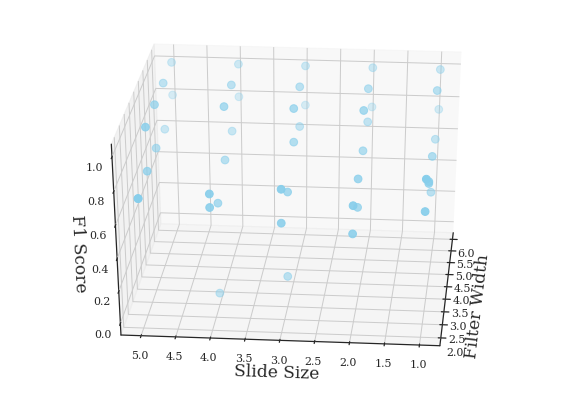

In [ ]:
# libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
fig = plt.figure(figsize=(10,7))
# plot
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Filter Width'], df['Slide Size'], df['F1 Score'], c='skyblue', s=60)
ax.view_init(30, 185)
ax.set_xlabel('Filter Width', fontsize=17)
ax.set_ylabel('Slide Size', fontsize=17)
ax.set_zlabel('F1 Score', fontsize=17)

plt.savefig('filter.png' , dpi=300) 

In [ ]:

TEST_PATH = 'testcase3.png'
rois = find_rois(TEST_PATH)
filtered_rects_test = filter_rois(rois , TEST_PATH)

LETTER_VALUES , train_ims = get_embeddings(filtered_rects , 'my-data.png' , mode='TRAIN' , filtersize=3 , slide=5 , pooling=0)
embedds , test = get_embeddings(filtered_rects_test , TEST_PATH , filtersize=3 , slide=5 , pooling=0)




In [ ]:
predictions = predict(embedds , LETTER_VALUES, cutoff=3.0)
# transformed_pred = le.transform(predictions)
f1_noise = precision_recall_fscore_support(predictions , GROUND_TRUTH , average='weighted')[0]

(24, 6, 6)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
GROUND_TRUTH = ['M' , '-1' , 'N' , '-1', 'O' , 
                '-1' , 'P' , '-1' , 
                'Q' , 'R' , 
                '-1' , 'S' , '-1' , 'T' , 
                '-1' , 'U' , '-1' , 'V' , 
                '-1' , 'W' , '-1' , 'X' ,
                '-1' , 'M']

TEST_PATH = 'resized-letters.png'
rois_test = find_rois(TEST_PATH)
rois_train = find_rois(IMAGE)
filtered_rects = filter_rois(rois_train , IMAGE , threshold=0.0025)

filtered_rects_test = filter_rois(rois_test , TEST_PATH , threshold=0.0040)

LETTER_VALUES , train_ims = get_embeddings(filtered_rects , 'my-data.png' , mode='TRAIN' , filtersize=3 , slide=5 , pooling=0)
embedds , test = get_embeddings(filtered_rects_test , TEST_PATH , filtersize=3 , slide=5 , pooling=0)
draw_rois('resized-letters.png' , filtered_rects_test)


In [ ]:
predictions = predict(embedds , LETTER_VALUES, cutoff=3.0)
# transformed_pred = le.transform(predictions)
f1_scale = precision_recall_fscore_support(predictions , GROUND_TRUTH , average='weighted')[0]

(24, 6, 6)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
f1_scale

0.9791666666666666

(-0.5, 5.5, 5.5, -0.5)

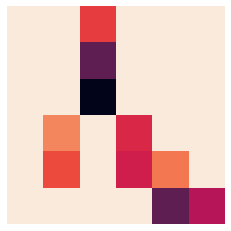

In [ ]:
plt.imshow(embedds[17])
plt.axis('off')

(-0.5, 5.5, 5.5, -0.5)

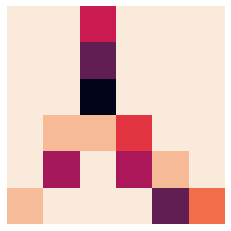

In [ ]:
plt.imshow(LETTER_VALUES['V'])
plt.axis('off')

In [ ]:
draw_rois(IMAGE, filtered_rects)

In [ ]:
df = pd.DataFrame({'Transformation':['Benchmark' , 'Noise' , 'Rotation' , 'Pixel Inversion' , 'Scaling'] , 'F1 Score':[f1 , f1_noise , 0.75 , f1 , f1_scale]})

In [ ]:
df['F1 Score']

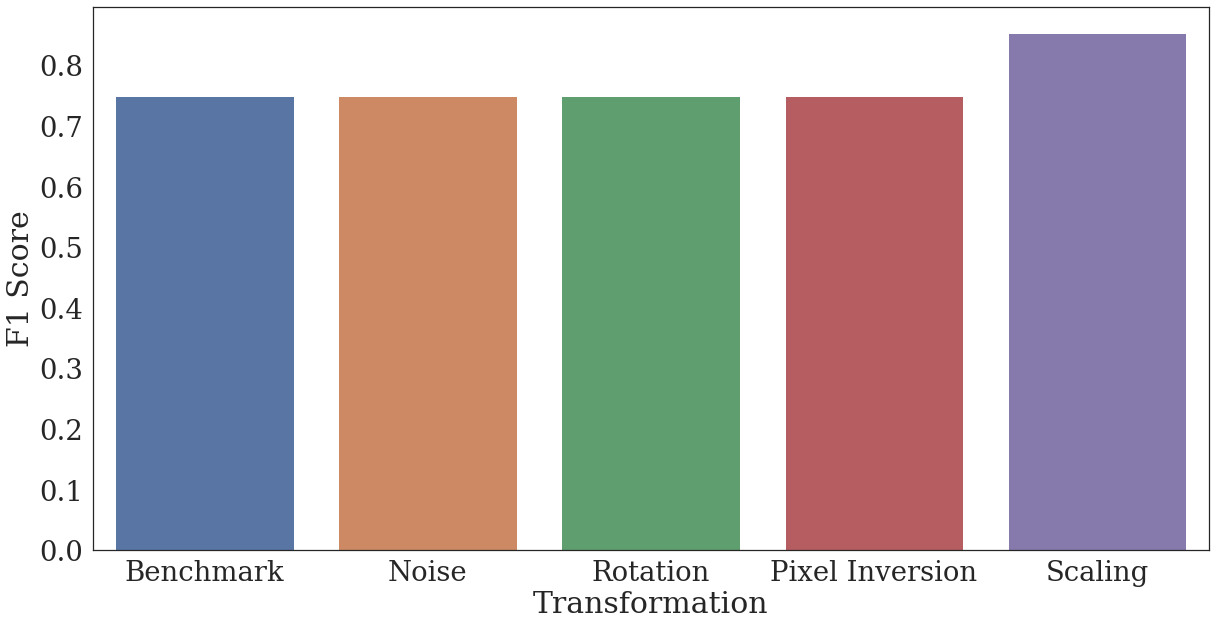

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="Transformation", y="F1 Score", data=df)
plt.savefig('compare.png')